# Week 10 Lecture Lab (Part 2)
### In this week's lecture lab, we will examine different methods of dimensionality reduction. We will examine two methods, the first being Principal Component Analysis (PCA) and the second being Autoencoders. To demonstrate dimensionality reduction, we will be using the sklearn wine dataset, which has a total of 178 observations, 13 features, and three output target labels. 

In [1]:
# make sure that you have seaborn version 0.11.0 installed 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn import __version__
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV
import random
random.seed(100)
plt.style.use('seaborn')

In [2]:
#load dataset
data= load_wine()

#create dataframe for features (X) 
X = pd.DataFrame(data['data'])
X.columns = data['feature_names']
print(X.shape)

#create dataframe for target (y)
y = pd.DataFrame(data['target'])
print(y.shape)
print(data['target_names'])

(178, 13)
(178, 1)
['class_0' 'class_1' 'class_2']


#### We will first examine PCA using sklearn's PCA decomposition method. This implementation follows the same structure as other sklearn implementations we have seen thus far. First, we must instantiate a PCA object, then fit it, and then transform data. When instantiating, we must select the number of principal components to use. For illustrative purposes, we will instantiate multiple PCA objects with different numbers of components and evaluate their performance. Since there are 13 features in the dataset, we will perform dimensionality reductions using 11, 9, 7, 5, 3, and 1 components.

In [3]:
#Instantiate PCA objects setting n_components to the number of reduced features
PCA_11 = PCA(n_components = 11)
PCA_9 = PCA(n_components = 9)
PCA_7 = PCA(n_components = 7)
PCA_5 = PCA(n_components = 5)
PCA_3 = PCA(n_components = 3)
PCA_1 = PCA(n_components = 1)

#list of objects
pca_objects = [PCA_11, PCA_9, PCA_7, PCA_5, PCA_3, PCA_1]

In [5]:
# Fit objects on data and transform into dimensionally reduced feature set
X_11 = pd.DataFrame(PCA_11.fit_transform(X))
X_9 = pd.DataFrame(PCA_9.fit_transform(X))
X_7 = pd.DataFrame(PCA_7.fit_transform(X))
X_5 = pd.DataFrame(PCA_5.fit_transform(X))
X_3 = pd.DataFrame(PCA_3.fit_transform(X))
X_1 = pd.DataFrame(PCA_1.fit_transform(X))

#list of datasets (including original)
datasets = [X, X_11, X_9, X_7, X_5, X_3, X_1]
print(X_9)

              0          1         2         3         4         5         6  \
0    318.562979  21.492131  3.130735 -0.250114  0.677078  0.568081 -0.619642   
1    303.097420  -5.364718  6.822835 -0.864035 -0.486096  0.014340  0.108865   
2    438.061133  -6.537309 -1.113223  0.912411  0.380651  0.672404  0.785819   
3    733.240139   0.192729 -0.917257 -0.541251  0.858662  0.599122  0.018770   
4    -11.571428  18.489995 -0.554422  1.360896  0.276442  0.768884 -0.309976   
..          ...        ...       ...       ...       ...       ...       ...   
173   -6.980211  -4.541137 -2.474707 -3.155920 -2.348927  1.439001 -0.026425   
174    3.131605   2.335191 -4.309931 -1.562181 -1.168003  0.128679  0.003859   
175   88.458074  18.776285 -2.237577 -4.820708 -1.057336  0.215000  0.648489   
176   93.456242  18.670819 -1.788392 -3.709352 -0.276956 -1.009229  0.414948   
177 -186.943190  -0.213331 -5.630510 -3.472987  0.007035  0.703636 -0.693761   

            7         8  
0   -0.199555

#### Inevitably, when you reduce the dimensionality of your data, you lose some information. As a measure of information retention, we consider the PCA model's explained variance attribute, which tells us how much variance (information) is retained post-transformation.

In [29]:
#sum the explained_varience_ratio across all principal components
for i in pca_objects:
  print(i.explained_variance_ratio_.sum())

print('sklearn: %s' % __version__)

0.9999997054469665
0.9999986059708891
0.9999959550599171
0.9999846861150248
0.9999221050741547
0.9980912304918974
sklearn: 0.22.2.post1


#### Did you notice something interesting? The variance barely reduces even when we have one principal component... why is this? We can perform a granular analysis exploring the amount of variance explained by each individual principal component to examine further. Let's consider the example with 11 principal components.


In [30]:
print(pd.DataFrame({'Component':[i for i in range(1,12)], 'Explained_var': PCA_11.explained_variance_ratio_.round(6)}).set_index('Component'))

           Explained_var
Component               
1               0.998091
2               0.001736
3               0.000095
4               0.000050
5               0.000012
6               0.000008
7               0.000003
8               0.000002
9               0.000001
10              0.000001
11              0.000000


#### As we can see, the first component explains 0.998091 of the information. As we reduce the number of components, a portion of the information is lost until we have a single component left. Let's try predicting with the original feature set and the transformed feature sets.

In [31]:
# split data by index into training and test sets following 80/20 scheme

n_train = round(0.8*y.shape[0])
indices = [i for i in range (y.shape[0])]
ind_train = random.sample(indices, n_train)

training = []
testing = []

for i in range(len(datasets)):
  training.append(datasets[i].iloc[ind_train, :])
  testing.append(datasets[i].drop(ind_train))

# split target into training and testing 

y_train = y.iloc[ind_train]
y_test = y.drop(ind_train)

In [32]:
#instantiate models in a list

models = [LogisticRegressionCV(cv =5, max_iter = 1000000, multi_class='auto') for i in range (7)]


In [33]:
#train models and predict on features
scores = []
for i in range(len(models)):
  scores.append(models[i].fit(training[i], y_train.values.ravel()).score(testing[i],y_test.values.ravel()))

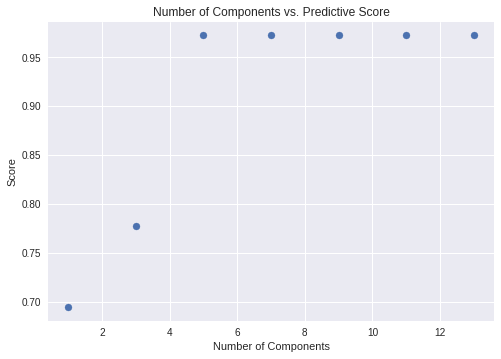

In [34]:
#plot the results of the scoring
plt.scatter([i for i in range(13,0,-2)], scores)
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('Number of Components vs. Predictive Score')
plt.show()

#### Let's now perform dimensionality reduction using an autoencoder, which is a type of neural network that has the same input as it does output. The hidden layer contains hidden units less equal to the number of dimensionally reduced features. In these experiments, we will evaluate our model's effectiveness a bit differently. We will consider the reconstruction error, which compares the reconstructed features to the original features. We will scale our features as a data preparation stage.

In [35]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled.astype(np.float32)

#### Next we will create our first autoencoder reducing the features to 11. For this, we will create the two parts of the autoencoder:

- The Encoder, that takes the data and compress it to a lower dimension and...
- The Decoder, that takes the compressed data and restores it to its original form.


The number of layers in the encoder and decoder layers are defined by the user, so they can become fairly complex. In this example we will make a very simple architecture:

- A linear layer that takes the encoder and reduces it to 11 features using tangent activation. This will be the encoder.
- A decoding layer to increase the data back to 13 layers with linear transform.

The code is as follows:

In [36]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(13,11),
            nn.Hardtanh(),
            )
        self.decoder = nn.Sequential(
            nn.Linear(11,13)
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#build model
auto_enc_11 = autoencoder()

#define loss function
loss_fn = torch.nn.MSELoss()

#define learning rate
learning_rate = 1e-1

#convert dataset to tensors
X_scaled = torch.from_numpy(X_scaled)
#train model
for t in range (5000):
  y_pred = auto_enc_11(X_scaled)
  loss = loss_fn(y_pred, X_scaled)
  if t % 1000 == 999:
        print(t, loss.item())
  auto_enc_11.zero_grad()
  loss.backward()
  with torch.no_grad():
        for param in auto_enc_11.parameters():
            param -= learning_rate * param.grad 

999 0.05006270855665207
1999 0.03152052313089371
2999 0.02750120498239994
3999 0.02525080181658268
4999 0.023685233667492867


#### In practice, we would consider the encoder (input + hidden layer) and the decoder (hidden + output) layer by extracting them from the trained model. In this example, we will transform the data and plot a distribution of the reconstruction error.

In [37]:
#pass scaled data to the autoencoder
X_reconstructed = auto_enc_11(X_scaled)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Reconstruction Error Distribution for Autoencoder')

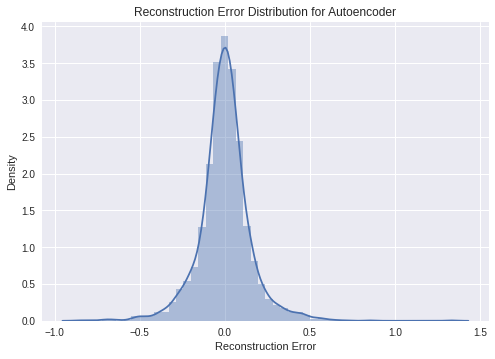

In [38]:
#plot the distribution of the reconstruction error
sns.distplot(X_scaled - X_reconstructed.detach().numpy())
plt.xlabel("Reconstruction Error")
plt.title("Reconstruction Error Distribution for Autoencoder")

If you want to use the encoded sections, you can simply call the `.encoder(data)` method that will return the encoded section of the autoencoder. The following code returns the compressed encoded training data in numpy format.

In [44]:
auto_enc_11.encoder(X_scaled).detach().numpy()

array([[ 0.28658402,  0.30370757, -0.46649587, ...,  0.59780174,
         0.30343676,  0.4326211 ],
       [ 0.38052204,  0.3609756 , -0.72055155, ..., -0.27226916,
         0.52317506,  0.40242508],
       [ 0.5687936 , -0.00612221, -0.89728606, ...,  0.78766316,
         0.04551781, -0.20049387],
       ...,
       [ 0.29057002,  0.5426839 ,  0.82326746, ...,  0.36742193,
         0.35832518,  0.75117654],
       [ 0.6888843 ,  0.6609665 ,  0.99880975, ...,  0.28834796,
        -0.19035465,  0.51122606],
       [-0.40389755,  0.05579337,  0.91501707, ...,  0.7517974 ,
        -0.3952077 ,  0.91289115]], dtype=float32)

That's it! You now have an autoencoder that reduces from 13 variables back to 11. Of course, you can be much more aggressive than that in your compression strategies.

Remember, as with any neural network model, the parameters need to be tuned to improve performance. As an exercise, try improving the performance of this model by reducing the reconstruction error. You may consider changing activation functions, learning rates, etc. If you are feeling ambitious, consider creating a stacked autoencoder (you will need to look this up) and see how it performs. Additionally, you could try implementing additional autoencoders to reduce the features even further as we did with the PCA. The best way to get familiar with neural networks is to practice!